HENRY - DATA SCIENCE 03 - PROYECTO INDIVIDUAL 02 - MATEO ROSALES - 23/09/2022

INTRODUCCION

El siguiente proyecto tiene como marco una organización E-commerce que se encarga de realizar envíos. Con la intención de resolver la problemática de envíos que llegan fuera de tiempo se decide llevar a cabo la tarea de desarrollar un modelo predictivo que pueda anticipar a partir de datos históricos envíos futuros que puedan causar inconvenientes. El dataset se compone de un archivo csv con datos de envíos pasados con la confirmación de si fueron entregados a tiempo o no, y un archivo csv con los mismos datos, pero sin esa confirmación. A continuación se explicará el proceso paso a paso de la confección del modelo.

DESARROLLO

Se importaron las librerías y módulos a utilizar. El primer grupo fue utilizado a lo largo de todo el proyecto, el segundo grupo sólo en la parte de modelado.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from scipy.stats import chi2_contingency
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier, BaggingClassifier

Se importó el archivo de datos para entrenar al modelo y se hicieron las primeras observaciones de las variables.

In [4]:
# DataFrame E-Commerce
dfec = pd.read_excel("E-Commerce_train.xlsx")
dfec

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8994,8995,D,Ship,3,1,217,3,low,F,1,4177,1
8995,8996,F,Ship,5,3,232,3,medium,M,3,4526,0
8996,8997,A,Ship,4,5,260,3,medium,F,6,4221,0
8997,8998,B,Ship,4,2,184,3,medium,F,5,5931,1


In [5]:
dfec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8999 entries, 0 to 8998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   8999 non-null   int64 
 1   Warehouse_block      8999 non-null   object
 2   Mode_of_Shipment     8999 non-null   object
 3   Customer_care_calls  8999 non-null   int64 
 4   Customer_rating      8999 non-null   int64 
 5   Cost_of_the_Product  8999 non-null   int64 
 6   Prior_purchases      8999 non-null   int64 
 7   Product_importance   8999 non-null   object
 8   Gender               8999 non-null   object
 9   Discount_offered     8999 non-null   int64 
 10  Weight_in_gms        8999 non-null   int64 
 11  Reached.on.Time_Y.N  8999 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 843.8+ KB


In [6]:
dfec.describe()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,8999.00000,8999.000000,8999.000000,8999.000000,8999.000000,8999.000000,8999.000000,8999.000000
mean,4500.00000,4.015113,2.994999,208.561507,3.511501,15.097678,3584.364596,0.635515
std,2597.93187,1.138934,1.413143,48.289172,1.532074,17.400040,1614.750194,0.481312
min,1.00000,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,2250.50000,3.000000,2.000000,168.000000,3.000000,4.000000,1857.000000,0.000000
50%,4500.00000,4.000000,3.000000,211.000000,3.000000,8.000000,4046.000000,1.000000
75%,6749.50000,5.000000,4.000000,249.500000,4.000000,19.000000,4999.500000,1.000000
max,8999.00000,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


Se modificó el nombre de las columnas para una mejor identificación.

In [7]:
dfec.columns=['IdOrden', 'Almacen','Transporte','LLamadasCliente','PuntajeCliente','CostoProd','ComprasPrevias','ImportanciaProd','GeneroCliente','Descuento','Peso(g)','LlegadaTiempo']
dfec.head(1)

,IdOrden,Almacen,Transporte,LLamadasCliente,PuntajeCliente,CostoProd,ComprasPrevias,ImportanciaProd,GeneroCliente,Descuento,Peso(g),LlegadaTiempo
0,1,D,Flight,4,2,177,3,low,F,44,1233,1


DISCRETIZACION

Se procedió a discretizar las variables categóricas para facilitar su manipulación. Se generó la segunda versión del DataFrame.

In [ ]:
df2=dfec
df2.ImportanciaProd.unique()
df2.GeneroCliente.unique()
df2.Almacen.unique()
df2.Transporte.unique()

In [9]:
df2.Transporte=df2.Transporte.map({'Flight':0,'Ship':1,'Road':2}).astype(int)
df2.ImportanciaProd=df2.ImportanciaProd.map({'low':0,'medium':1,'high':2}).astype(int)
df2.GeneroCliente=df2.GeneroCliente.map({'F':0,'M':1}).astype(int)
df2.Almacen=df2.Almacen.map({'A':0,'B':1,'C':2,'D':3,'F':4}).astype(int)
df2.head(1)

,IdOrden,Almacen,Transporte,LLamadasCliente,PuntajeCliente,CostoProd,ComprasPrevias,ImportanciaProd,GeneroCliente,Descuento,Peso(g),LlegadaTiempo
0,1,3,0,4,2,177,3,0,0,44,1233,1


Con el método Pairplot de Seaborn se procedió a analizar las relaciones entre las variables y con relación a la variable objetivo. Se evaluó además la distribución de la variable objetivo en la muestra.

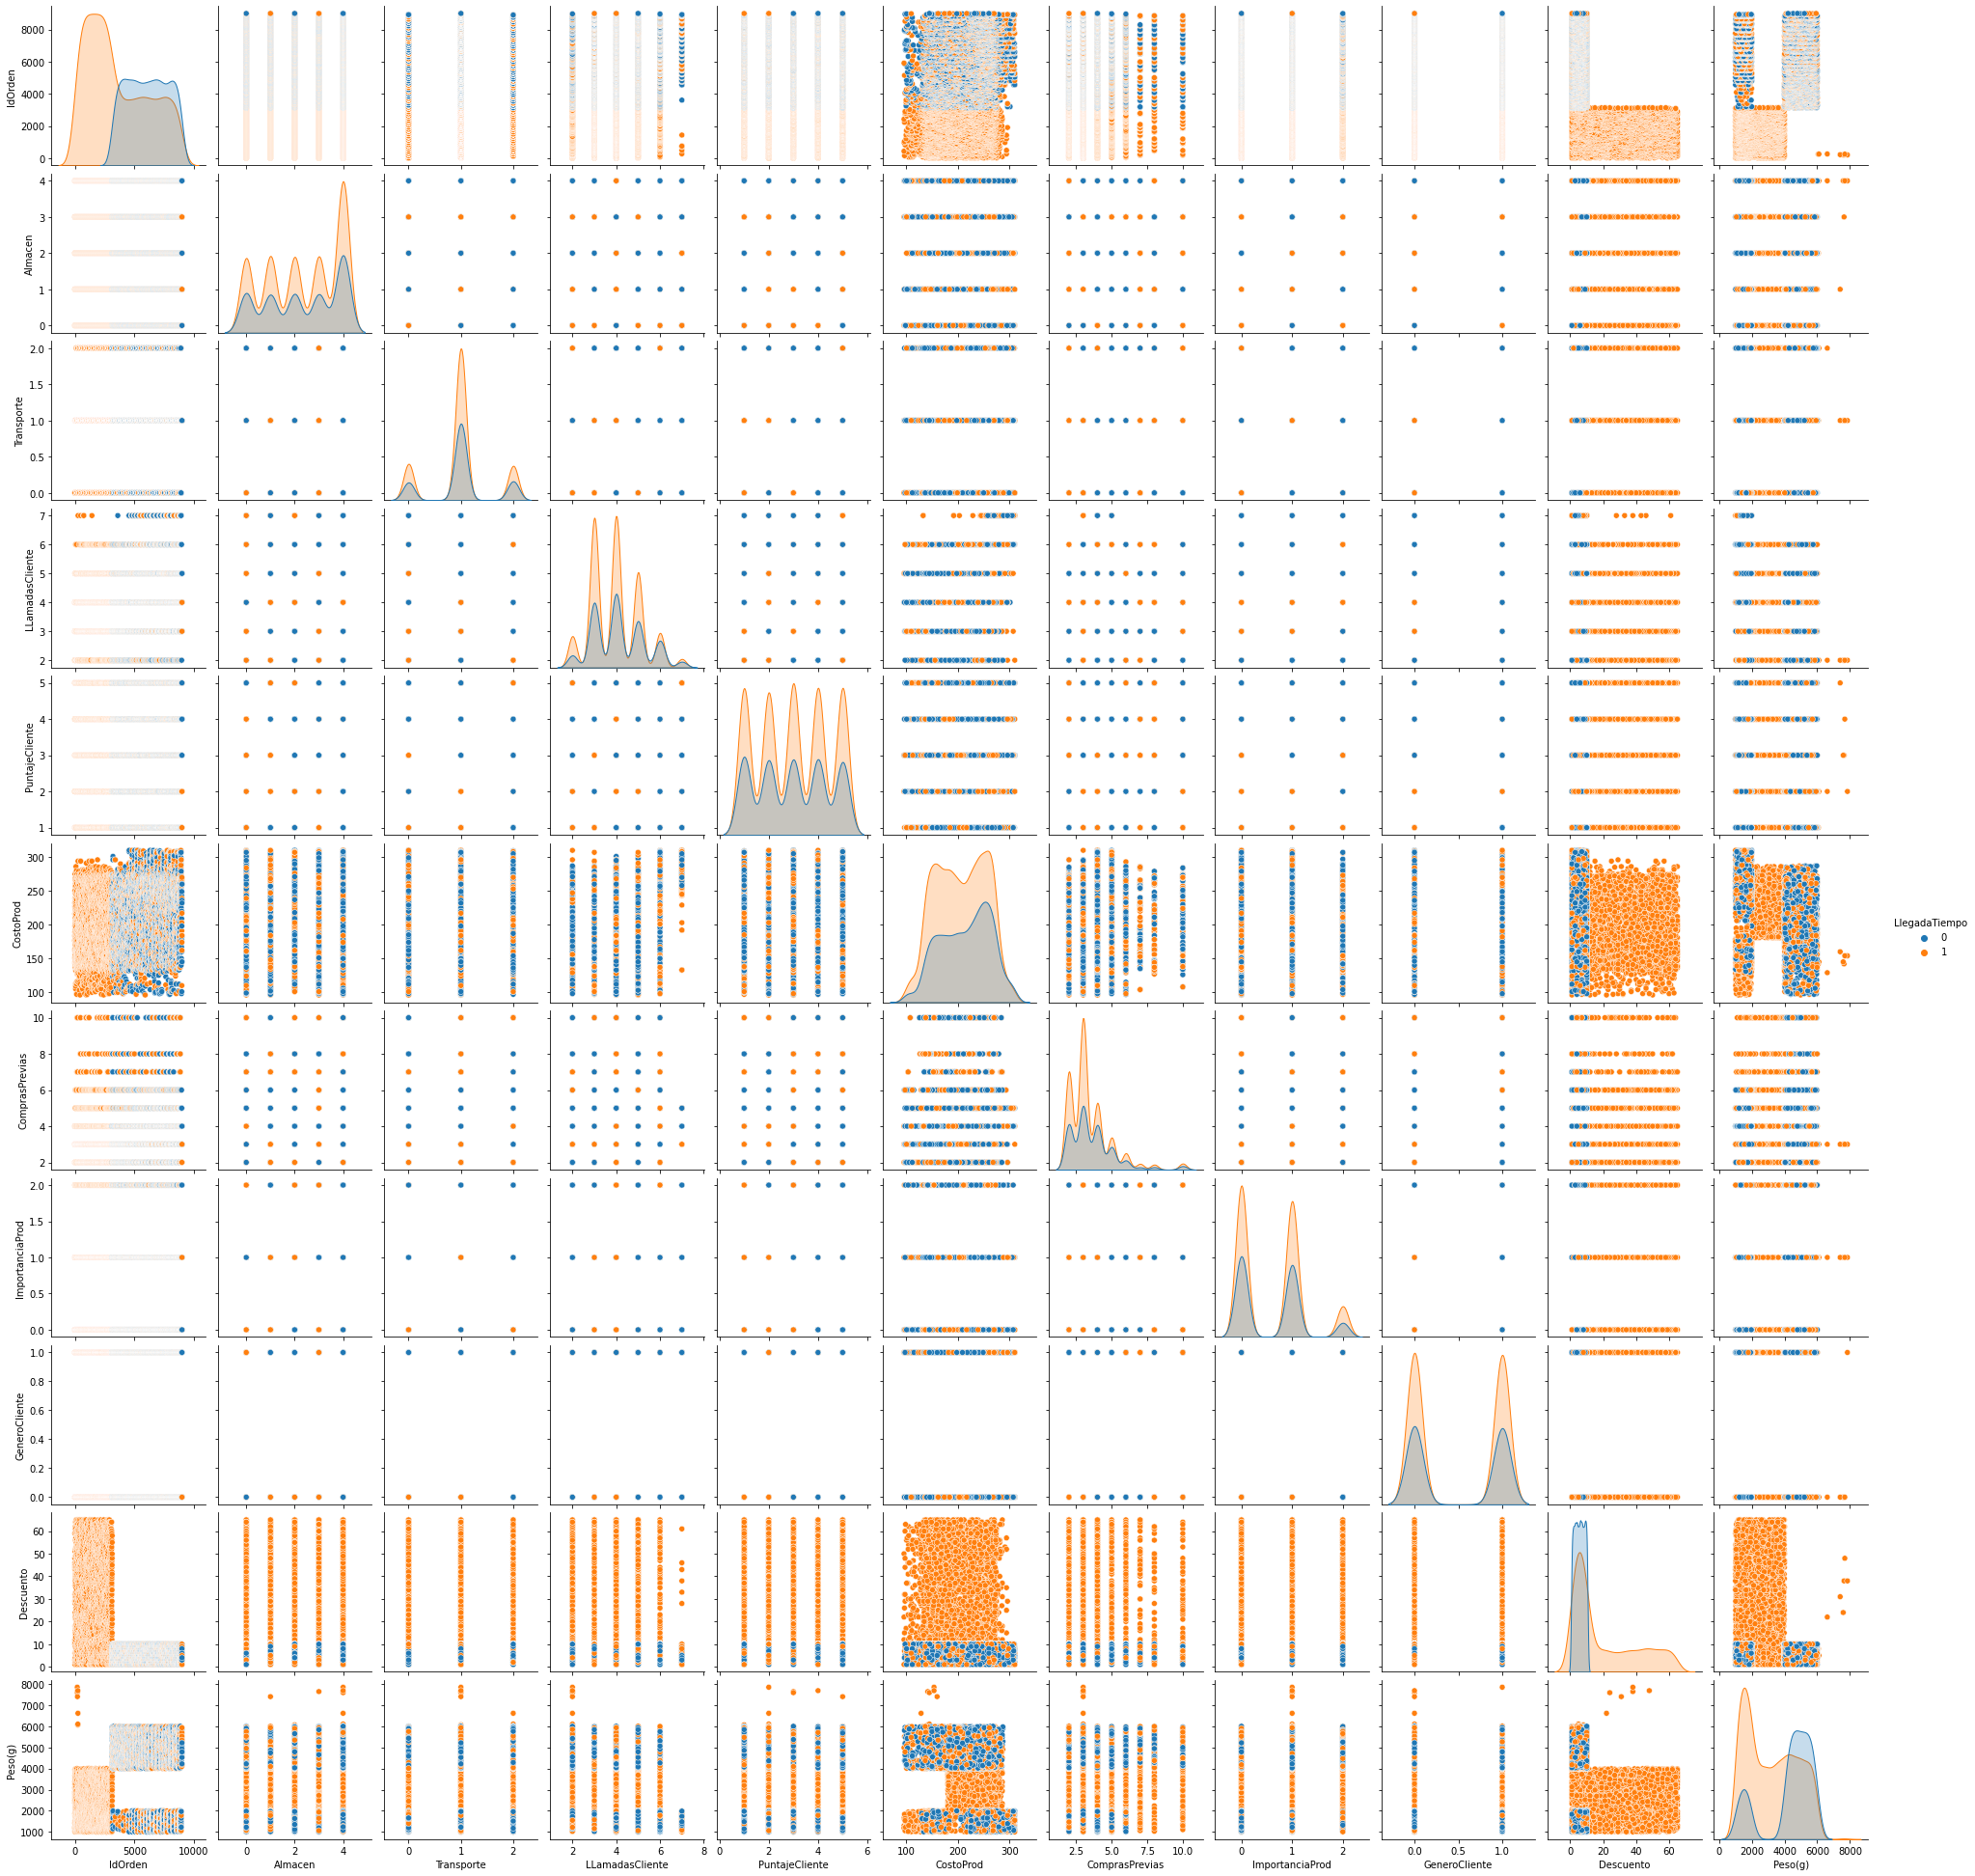

In [11]:
sns.pairplot(df2, hue="LlegadaTiempo")
plt.show()

c:\Users\Mateo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


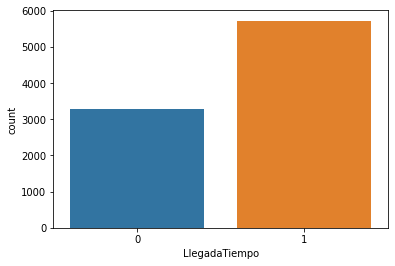

In [10]:
sns.countplot(df2.LlegadaTiempo)
plt.show()

BALANCEO

Se observó un marcado desbalanceo en las categorías de la variable objetivo. Pudo verse además en el Pairplot que en las órdenes con bajo IdOrden no se encuentran envíos entregados fuera de tiempo. Entendiendo que las órdenes siguen un orden cronológico, teniendo en cuenta que la problemática surge a partir de la orden 3136 y con el fin de balancear la muestra, se consideraron para el análisis los datos con IdOrden mayor a 3135. Se generó la tercera versión del DataFrame.

In [12]:
df3=df2[df2.IdOrden>3135]
df3.index = range(df3.shape[0])
df3.head(1)

,IdOrden,Almacen,Transporte,LLamadasCliente,PuntajeCliente,CostoProd,ComprasPrevias,ImportanciaProd,GeneroCliente,Descuento,Peso(g),LlegadaTiempo
0,3136,1,2,6,5,141,3,1,1,8,5031,0


c:\Users\Mateo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


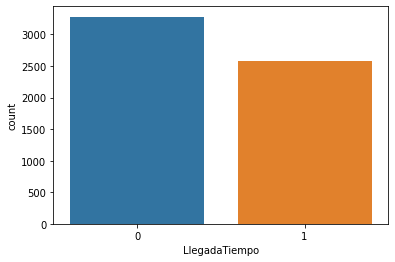

In [13]:
sns.countplot(df3.LlegadaTiempo)
plt.show()

VISUALIZACION

Con la nueva modificación hecha al DataFrame se procedió a graficar histogramas, para variables categóricas, y gráficos de dispersión, para variables continuas con el propósito de poder contemplar relaciones con la variable objetivo.

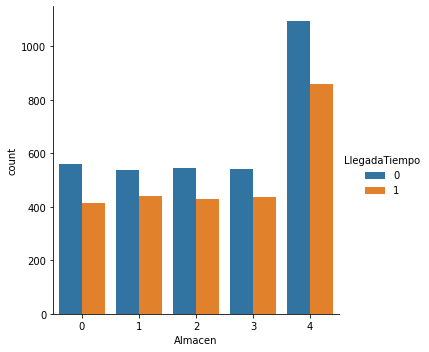

In [14]:
sns.catplot(data=df3, x="Almacen", hue="LlegadaTiempo", kind="count")

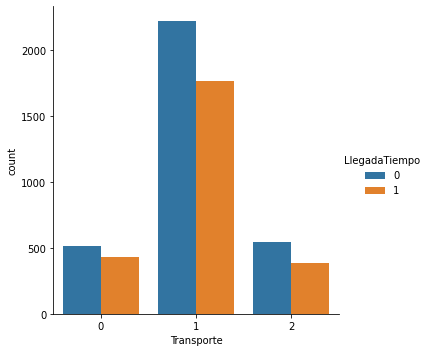

In [15]:
sns.catplot(data=df3, x="Transporte", hue="LlegadaTiempo", kind="count")

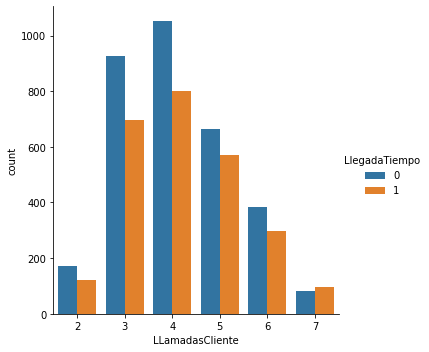

In [16]:
sns.catplot(data=df3, x="LLamadasCliente", hue="LlegadaTiempo", kind="count")

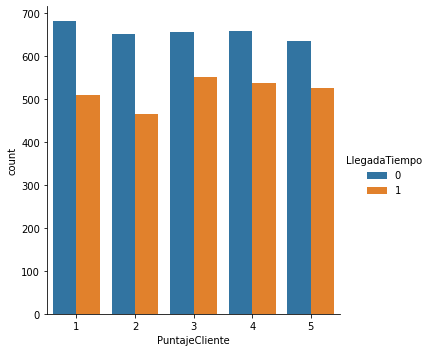

In [17]:
sns.catplot(data=df3, x="PuntajeCliente", hue="LlegadaTiempo", kind="count")

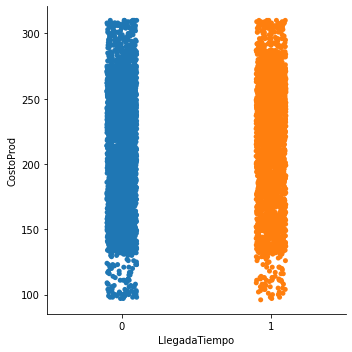

In [18]:
sns.catplot(data=df3, x ="LlegadaTiempo", y ="CostoProd",ci = "sd", estimator=np.median)

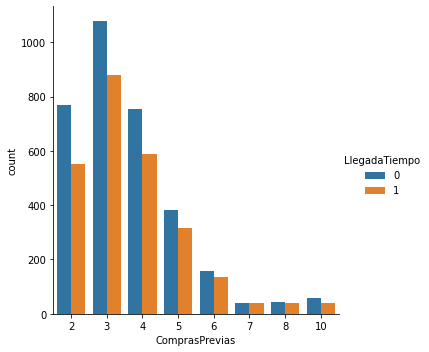

In [19]:
sns.catplot(data=df3, x="ComprasPrevias", hue="LlegadaTiempo", kind="count")

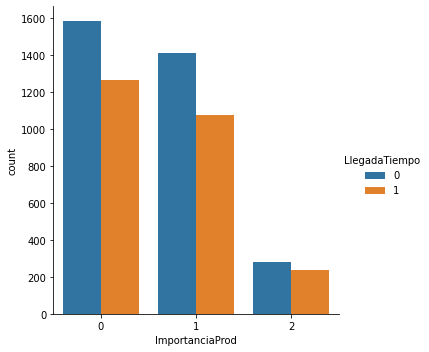

In [20]:
sns.catplot(data=df3, x="ImportanciaProd", hue="LlegadaTiempo", kind="count")

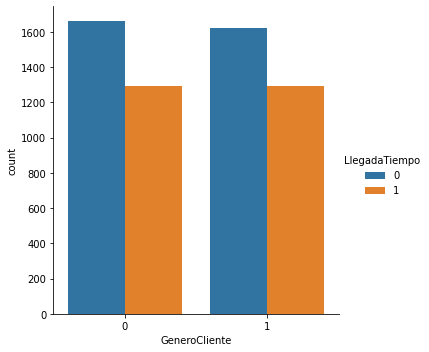

In [21]:
sns.catplot(data=df3, x="GeneroCliente", hue="LlegadaTiempo", kind="count")

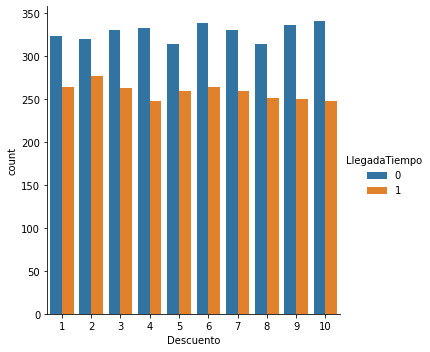

In [22]:
sns.catplot(data=df3, x="Descuento", hue="LlegadaTiempo", kind="count")

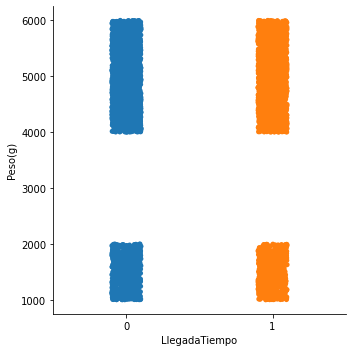

In [23]:
sns.catplot(data = df3, x = "LlegadaTiempo", y = "Peso(g)",ci = "sd",estimator=np.median)

NORMALIZACION

Con el fin de establecer correlaciones de una manera eficiente se procedió a normalizar las variables. Al no observarse claros outliers que puedan interferir en el análisis se normalizaron las variables con el método minmax que acota los valores entre 0 y 1. Se generó así la cuarta versión del DataFrame.

In [24]:
def minmax_norm(df):
    return (df - df.min()) / ( df.max() - df.min())
df4 = minmax_norm(df3)
df4.head(1)

,IdOrden,Almacen,Transporte,LLamadasCliente,PuntajeCliente,CostoProd,ComprasPrevias,ImportanciaProd,GeneroCliente,Descuento,Peso(g),LlegadaTiempo
0,0.0,0.25,1.0,0.8,1.0,0.21028,0.125,0.5,1.0,0.777778,0.806161,0.0


CORRELACIONES

Para seguir con el proceso de búsqueda de correlaciones entre variables se generó un mapa de calor y posteriormente una prueba de dependecia de Chi-cuadrado para cada variable categórica.

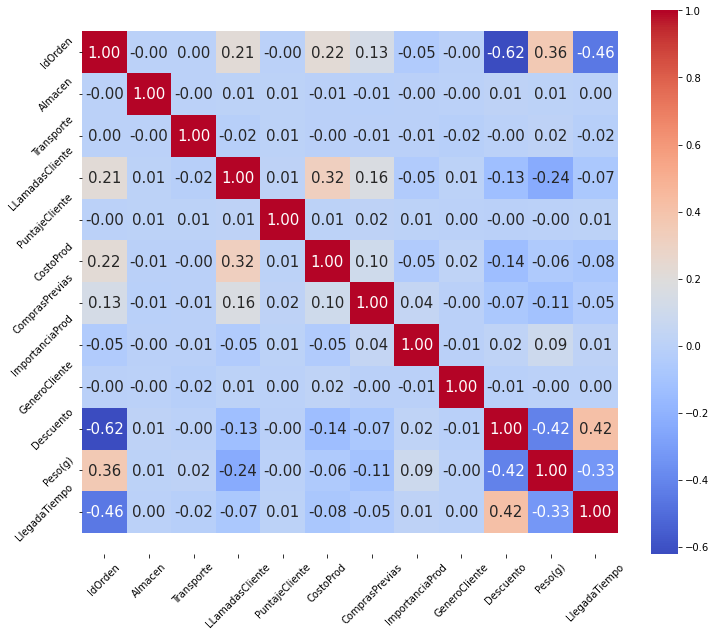

In [25]:
def plot_corre_heatmap(corr):
    plt.figure(figsize=(12,10))
    sns.heatmap(corr, cbar = True,  square = False, annot=True, fmt= '.2f'
                ,annot_kws={'size': 15},cmap= 'coolwarm')
    plt.xticks(rotation = 45)
    plt.yticks(rotation = 45)
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.show()
corr = df2.corr()
plot_corre_heatmap(corr)

Para las pruebas de dependencia de Chi-cuadrado se utilizó el método chi2_contingency de la librería spicy.stats. El valor que devuelve como resultado cuanto más alto refleja menor relación entre la variable y la variable resultado.

In [26]:
# Almacen
obs_almacen=pd.crosstab(index=df4.LlegadaTiempo,columns=df4.Almacen,margins=True)
test_almacen=chi2_contingency(obs_almacen)
esp_almacen= pd.DataFrame(test_almacen[3])
obs_almacen_rel=round(obs_almacen.apply(lambda r:r/len(df4)*100,axis=1),2)
esp_almacen_rel=round(esp_almacen.apply(lambda r:r/len(df4)*100,axis=1),2)
test_almacen[1]

0.9988897230907767

In [27]:
# Transporte
obs_transporte=pd.crosstab(index=df4.LlegadaTiempo,columns=df4.Transporte,margins=True)
test_transporte=chi2_contingency(obs_transporte)
esp_transporte= pd.DataFrame(test_transporte[3])
obs_transporte_rel=round(obs_transporte.apply(lambda r:r/len(df4)*100,axis=1),2)
esp_transporte_rel=round(esp_transporte.apply(lambda r:r/len(df4)*100,axis=1),2)
test_transporte[1]

0.7195722841720769

In [28]:
# LlamadasCliente
obs_llamadas=pd.crosstab(index=df4.LlegadaTiempo,columns=df4.LLamadasCliente,margins=True)
test_llamadas=chi2_contingency(obs_llamadas)
esp_llamadas= pd.DataFrame(test_llamadas[3])
obs_llamadas_rel=round(obs_llamadas.apply(lambda r:r/len(df4)*100,axis=1),2)
esp_llamadas_rel=round(esp_llamadas.apply(lambda r:r/len(df4)*100,axis=1),2)
test_llamadas[1]

0.4128577956090717

In [29]:
# PuntajeCliente
obs_puntaje=pd.crosstab(index=df4.LlegadaTiempo,columns=df4.PuntajeCliente,margins=True)
test_puntaje=chi2_contingency(obs_puntaje)
esp_puntaje= pd.DataFrame(test_puntaje[3])
obs_puntaje_rel=round(obs_puntaje.apply(lambda r:r/len(df4)*100,axis=1),2)
esp_puntaje_rel=round(esp_puntaje.apply(lambda r:r/len(df4)*100,axis=1),2)
test_puntaje[1]

0.8399087854879581

In [30]:
# ComprasPrevias
obs_compras=pd.crosstab(index=df4.LlegadaTiempo,columns=df4.ComprasPrevias,margins=True)
test_compras=chi2_contingency(obs_compras)
esp_compras= pd.DataFrame(test_compras[3])
obs_compras_rel=round(obs_compras.apply(lambda r:r/len(df4)*100,axis=1),2)
esp_compras_rel=round(esp_compras.apply(lambda r:r/len(df4)*100,axis=1),2)
test_compras[1]

0.9679879643142185

In [31]:
# ImportanciaProd
obs_importancia=pd.crosstab(index=df4.LlegadaTiempo,columns=df4.ImportanciaProd,margins=True)
test_importancia=chi2_contingency(obs_importancia)
esp_importancia= pd.DataFrame(test_importancia[3])
obs_importancia_rel=round(obs_importancia.apply(lambda r:r/len(df4)*100,axis=1),2)
esp_importancia_rel=round(esp_importancia.apply(lambda r:r/len(df4)*100,axis=1),2)
test_importancia[1]

0.942946324834434

In [32]:
# GeneroCliente
obs_genero=pd.crosstab(index=df4.LlegadaTiempo,columns=df4.GeneroCliente,margins=True)
test_genero=chi2_contingency(obs_genero)
esp_genero= pd.DataFrame(test_genero[3])
obs_genero_rel=round(obs_genero.apply(lambda r:r/len(df4)*100,axis=1),2)
esp_genero_rel=round(esp_genero.apply(lambda r:r/len(df4)*100,axis=1),2)
test_genero[1]

0.9918720017460448

In [33]:
# Descuento
obs_descuento=pd.crosstab(index=df4.LlegadaTiempo,columns=df4.Descuento,margins=True)
test_descuento=chi2_contingency(obs_descuento)
esp_descuento= pd.DataFrame(test_descuento[3])
obs_descuento_rel=round(obs_descuento.apply(lambda r:r/len(df4)*100,axis=1),2)
esp_descuento_rel=round(esp_descuento.apply(lambda r:r/len(df4)*100,axis=1),2)
test_descuento[1]

0.9999745232341996

SELECCION DE VARIABLES

Luego del análisis no se pudieron encontrar correlaciones claras entre variables ni con la variable objetivo. Se procedió a eliminar la columna IdOrden al considerarla irrelevante. Se tomó la decisión de disponer de las demás columnas. Se generó una quinta versión del DataFrame.

In [34]:
df5=df4.drop(columns=['IdOrden'])
df5.head(1)

,Almacen,Transporte,LLamadasCliente,PuntajeCliente,CostoProd,ComprasPrevias,ImportanciaProd,GeneroCliente,Descuento,Peso(g),LlegadaTiempo
0,0.25,1.0,0.8,1.0,0.21028,0.125,0.5,1.0,0.777778,0.806161,0.0


MODELADO

Para la etapa de modelado se dividió la muestra en 80% para entrenar al modelo y 20% para testearlo. Se generó una función reporte para poder determinar con mayor facilidad las métricas que describen al modelo y para poder observar la matriz confusión correspondiente.

In [35]:
X = df5.drop(columns=['LlegadaTiempo'])
y = df5.LlegadaTiempo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [36]:
# Reporte métricas y matriz confusion
def reporte(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    matrix = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(matrix)
    cm_display.plot()
    plt.show()

MODELOS

Se llevaron a cabo diferentes modelos para dar con el que mejor ajuste los datos. Se trabajó con los siguientes modelos de clasificación:

 * Regresión logística

* Árboles de decisión

* Vecinos más cercanos (KNN)

 * Support vector machines (SVM)

Se generaron además los siguientes métodos de ensamble:

* Bagging

* Boosting

* Stacking

Las librerías y módulos utilizados se encuentran al inicio del archivo. Se trabajó en su mayoría con la librería sklearn, a excepción del método de boosting que utiliza la librería xgboost. Se implementó el método GridSearchCV para la optimización de parámetros. Se muestran los modelos a continuación:

In [ ]:
# Regresion logistica

for i in ['l1', 'l2', 'elasticnet','none']:
    for j in ['newton-cg','lbfgs','sag','saga']:
        try:
            model = LogisticRegression(penalty=i, solver=j)
            model.fit(X_train,y_train)
            y_pred_reg = model.predict(X_test.values)
            print('\npenalty:',i,'- solver',j)
            reporte(y_test, y_pred_reg)
        except:
            print( 'No se puede con:',i,j)
            pass

In [ ]:
#Arbol de decision

param_grid = {'criterion':['gini', 'entropy', 'log_loss'],
              'splitter': ['best','random'], 
              'max_depth':[None,3,5],
              'class_weight':[{0: 1, 1: 1},{0: 1, 1: 5}, {0: 1, 1: 3}]}

arbol = DecisionTreeClassifier()
model = GridSearchCV(arbol, param_grid=param_grid, cv=5)
model.fit(X_train,y_train)
print("Mejores hiperparámetros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')
y_pred_arbol = model.predict(X_test)
reporte(y_test,y_pred_arbol)

In [ ]:
# Vecinos mas cercanos (KNN)

param_grid = {'n_neighbors':np.arange(1, 20),
              'weights': ['uniform', 'distance'], 
              'leaf_size':[1,3,5,7,10],
              'algorithm':['auto', 'kd_tree']}

clf = KNeighborsClassifier()
model = GridSearchCV(clf, param_grid=param_grid, cv=5)
model.fit(X_train,y_train)
print("Mejores hiperparámetros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')
y_pred_knn = model.predict(X_test.values)
reporte(y_test,y_pred_knn)

In [ ]:
# Support vector machines (SVC)

param_grid = {'gamma': ['scale','auto']}

svc = SVC()
model = GridSearchCV(svc, param_grid=param_grid, cv=5)
model.fit(X_train,y_train)
print("Mejores hiperparámetros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')
y_pred_svc = model.predict(X_test)
reporte(y_test, y_pred_svc)

In [ ]:
# Bagging

clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), bootstrap_features=False, n_estimators= 100, n_jobs = -1)
clf.fit(X_train, y_train)
y_pred_bag = clf.predict(X_test)
reporte(y_test, y_pred_bag)

In [ ]:
# Boosting

clf_xgb = xgb.XGBClassifier(n_estimators=150, seed=42, use_label_encoder= False)
clf_xgb.fit(X_train, y_train)
y_test_boost = clf_xgb.predict(X_test)
reporte(y_test, y_test_boost)

In [ ]:
# Stacking

svc1 = SVC(gamma='scale')
svc2 = SVC(gamma='auto')
knn1 = KNeighborsClassifier(n_neighbors=1)
knn2 = KNeighborsClassifier(n_neighbors=3)
knn3 = KNeighborsClassifier(n_neighbors=5)
knn4 = KNeighborsClassifier(n_neighbors=10)
knn5 = KNeighborsClassifier(n_neighbors=15)
knn6 = KNeighborsClassifier(n_neighbors=20)
arbol1 = DecisionTreeClassifier(criterion='gini',max_depth=7,splitter='best',class_weight={0: 1, 1: 3})
arbol2 = DecisionTreeClassifier(criterion='gini',max_depth=5,splitter='best',class_weight={0: 1, 1: 3})
arbol3 = DecisionTreeClassifier(criterion='gini',max_depth=3,splitter='best',class_weight={0: 1, 1: 3})
arbol4 = DecisionTreeClassifier(criterion='gini',max_depth=7,splitter='best',class_weight={0: 1, 1: 1})
arbol5 = DecisionTreeClassifier(criterion='gini',max_depth=5,splitter='best',class_weight={0: 1, 1: 1})
arbol6 = DecisionTreeClassifier(criterion='gini',max_depth=3,splitter='best',class_weight={0: 1, 1: 1})

estimator_list = [('svc1',svc1),('svc2',svc2),('knn1',knn1),('knn2',knn2),('knn3',knn3),('knn4',knn4),('knn5',knn5),('knn6',knn6),
                    ('arbol1',arbol1),('arbol2',arbol2),('arbol3',arbol3),('arbol4',arbol4),('arbol5',arbol5),('arbol6',arbol6),]

stack_model = StackingClassifier(estimators=estimator_list, final_estimator=LogisticRegression())
stack_model.fit(X_train, y_train)
y_pred_stack = stack_model.predict(X_test)
reporte(y_test, y_pred_stack)

MODELO FINAL

Para realizar el testeo del modelo se procedió a realizar la importación del segundo archivo csv que contiene los datos sin la columna de la variable objetivo. Se discretizaron y normalizaron las variables.

In [37]:
# Importacion
dftest = pd.read_excel("E-Commerce_test.xlsx")

# Discretizacion
dftest.Mode_of_Shipment=dftest.Mode_of_Shipment.map({'Flight':0,'Ship':1,'Road':2}).astype(int)
dftest.Product_importance=dftest.Product_importance.map({'low':0,'medium':1,'high':2}).astype(int)
dftest.Gender=dftest.Gender.map({'F':0,'M':1}).astype(int)
dftest.Warehouse_block=dftest.Warehouse_block.map({'A':0,'B':1,'C':2,'D':3,'F':4}).astype(int)

# Normalizacion
dft = minmax_norm(dftest) 

# Limpieza de variables
X_ecom=dft.drop(columns=['ID'])
X_ecom.head(1)

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms
0,1.0,0.5,0.6,0.0,0.434579,0.0,0.5,1.0,1.0,0.84951


Luego de un proceso evaluativo de modelos se decidió optar por un árbol de decisión con los parámetros que se muestran a continuación. Para determinar el mejor modelo se tuvo en cuenta el parámetro de recall del valor 1 de la variable objetivo debido a que la organización apunta identificar de manera eficiente que pedidos llegan a tiempo, de esta manera poder centralizar los recursos en aquellos casos sospechosos de incunmplir con la entrega a tiempo.   

La siguiente función recibe un parámetro booleano, si es True guarda las predicciones en un archivo csv, si es False procede a hacer el reporte del modelo. Se muestran los resultados a continuación:

In [78]:
# Modelo final

def modelo_final(boolean):
    test2 = DecisionTreeClassifier(criterion='gini',max_depth=7,splitter='best',class_weight={0: 1, 1: 3})
    test2.fit(X_train,y_train)
    if boolean==True:
        y_pred = test2.predict(X_ecom)
        pred=pd.DataFrame(y_pred)
        pred.columns=['pred']
        pred.to_csv("MateoRosales.csv",index=False)
    else:
        y_pred = test2.predict(X_test)
        reporte(y_test, y_pred)

              precision    recall  f1-score   support

         0.0       0.57      0.08      0.14       664
         1.0       0.43      0.93      0.59       509

    accuracy                           0.45      1173
   macro avg       0.50      0.50      0.36      1173
weighted avg       0.51      0.45      0.33      1173



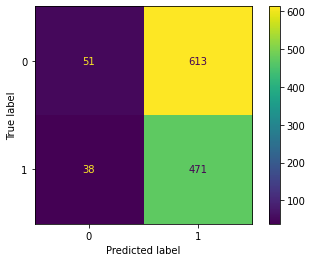

In [79]:
modelo_final(False)

CONCLUSION

Podemos observar que con el modelo considerado se obtiene un recall de 0.93 en la categoría 1 de la variable objetivo, por lo que cumple con el finalidad de predecir de manera efectiva los verdaderos positivos. Por otro lado, puede verse que el accuracy total del modelo es de 0.45, esto significa que pudimos predecir de manera correcta menos de la mitad de los casos. Esto no es del todo deseado, por lo que podemos concluir que si bien cumple con el objetivo primario, no llega a ser del todo satisfactorio y se requerirán mayores análisis para lograr una predicción más fehaciente. 